In [ ]:
import tensorflow as tf

print(tf.__version__)

In [ ]:
import numpy as np
import pandas as pd


df = pd.read_csv('/content/drive/My Drive/MachineLearning/train.csv')
display(df.head())

In [1]:
from sklearn.metrics import classification_report

y_true = [0, 1 ,2 ,2 ,2]   # 정답
y_pred = [0, 0, 2, 2, 1]   # 우리 model이 예측한 값

target_name = ['thin', 'normal', 'fat']

print(classification_report(y_true,y_pred,target_names=target_name))

              precision    recall  f1-score   support

        thin       0.50      1.00      0.67         1
      normal       0.00      0.00      0.00         1
         fat       1.00      0.67      0.80         3

    accuracy                           0.60         5
   macro avg       0.50      0.56      0.49         5
weighted avg       0.70      0.60      0.61         5



In [2]:
from sklearn.metrics import confusion_matrix

y_true = [2, 0, 2, 2, 0 ,1]
y_pred = [0, 0, 2, 2, 0, 2]

confusion_matrix(y_true,y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


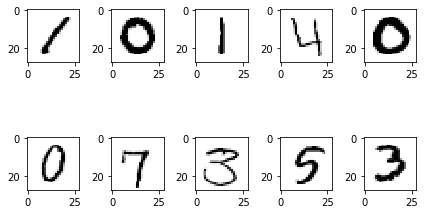

### 학습 시작 ###
Loss : 1.5621126890182495
Loss : 0.45062878727912903
Loss : 0.33470839262008667
Loss : 0.28387293219566345
Loss : 0.2520306706428528
Loss : 0.2305193543434143
Loss : 0.21516665816307068
Loss : 0.203637033700943
Loss : 0.1946011334657669
Loss : 0.1873025745153427
### 학습 끝 ###
              precision    recall  f1-score   support

       num 0       0.95      0.97      0.96      2890
       num 1       0.96      0.97      0.97      3255
       num 2       0.91      0.90      0.91      2901
       num 3       0.90      0.89      0.89      3053
       num 4       0.92      0.94      0.93      2836
       num 5       0.87      0.88      0.87      2676
       num 6       0.95      0.95      0.95      2894
       num 7       0.94      0.92      0.93      3067
       num 8       0.88      0.88      0.88      2859
       num 9       0.89      0.90      0.89      2969

    accuracy                           0.92     29400
   macro avg       0.92      0.92      0.92     29400
weight

In [2]:
%reset

# Tensorflow 1.15버전을 가지고 MNIST예제를 구현

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# import seaborn as sns    # confusion matrix를 heatmap을 통해서 그래프 출력   
from sklearn.preprocessing import MinMaxScaler   # Normalization
from sklearn.model_selection import train_test_split # train, test 분리
from sklearn.model_selection import KFold        # Cross Validation
from sklearn.metrics import classification_report, confusion_matrix

# tf.reset_default_graph()

# 1. Raw Data Loading
df = pd.read_csv('/Users/admin/Downloads/Digit_Recognizer_train.csv')
# display(df.head(), df.shape)   # (42000, 785)

# 2. 결측치와 이상치 처리
#    결측치를 찾고 만약 결측치가 존재하면 수정
#    이상치를 찾고 만약 있으면 이상치를 수정(scipy의 zscore이용하면 편해요!)
#    결측치와 이상치가 MNIST는 존재하지 않아요!!

# 3. 사용하는 데이터가 이미지 데이터예요!!
#    어떤 이미지인지 한번 확인하고 갈께요!!
#    df에서 label column은 제외하고 pixel데이터만 들고올꺼예요!!
img_data = df.drop('label', axis=1, inplace=False).values  
     # 이미지들의 pixel 데이터만 ndarray로 추출(2차원)
# 이런 이미지 데이터를 화면에 출력
fig = plt.figure()  # 출력할 전체 화면을 지칭하는 객체를 가져와요!
# fig안에 subplot을 만들꺼예요!! 이 subplot을 저장할 list를 하나 만들어요!!
fig_arr = list()

for n in range(10):
    fig_arr.append(fig.add_subplot(2,5,n+1))
    fig_arr[n].imshow(img_data[n].reshape(28,28), cmap='Greys', 
                      interpolation='nearest')

plt.tight_layout()
plt.show()

# 4. Data Split
#    데이터는 크게 3부분으로 나누어야 해요!
#    일단 2부분으로 나누어요! (train용, test용)
#    여기서 train용이라고 되어 있는 데이터를 다시 2부분으로 분리(train,validation)
#    train : 학습용(반복학습으로 모델을 완성)
#    validation : 모델 수정용도의 데이터 셋
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop('label', axis=1), df['label'], test_size=0.3, 
                 random_state=0)
                 
# 5. Normalization(x_data, 독립변수의 처리)
scaler = MinMaxScaler()   # 객체 생성
scaler.fit(x_data_train)  # 객체에 정보를 제공
x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

del x_data_train   
del x_data_test

# 6. 지금해결해야 하는 문제가 multinomial이예요!
#    t_data(label데이터, 정답)를 one hot 형태로 변형

sess = tf.Session()   # Tensorflow node를 실행하기 위해서 session을 생성

# depth는 label의 종류 개수
t_data_train_onehot = sess.run(tf.one_hot(t_data_train, depth=10))  
t_data_test_onehot = sess.run(tf.one_hot(t_data_test, depth=10))

###########################################
# traing용, test용 데이터가 준비되었어요!!

###########################################
# Tensorflow 구현

# 1. placeholder
# X의 의미는 x_data(독립변수)를 받아들이기 위한 placeholder
X = tf.placeholder(shape=[None,784], dtype=tf.float32)
T = tf.placeholder(shape=[None,10], dtype=tf.float32)

# 2. Weight, bias
W = tf.Variable(tf.random.normal([784,10]), name='weight')
b = tf.Variable(tf.random.normal([10]), name='bias')

# 3. Model(Hypothesis)  => Multinomial
logit = tf.matmul(X,W) + b   # Linear Regression
H = tf.nn.softmax(logit)     # Multinomial Hypothesis

# 4. loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit,
                                                                 labels=T))

# 5. Optimizer를 이용한 train(Optimizer는 loss값을 줄이는 알고리즘)
train = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)

# 6. 학습용 parameter setting (기본적으로 2개는 설정)
num_of_epoch = 100
batch_size = 100

# 7. 학습진행
def run_train(sess,train_x, train_t):
    print('### 학습 시작 ###')
    sess.run(tf.global_variables_initializer())  # tf.Variable 초기화(W,b)

    total_batch = int(train_x.shape[0] / batch_size)
    for step in range(num_of_epoch):

        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_t = train_t[i*batch_size:(i+1)*batch_size]
            _, loss_val = sess.run([train,loss], feed_dict={X:batch_x,
                                                            T:batch_t})
        if step % 10 == 0:
            print('Loss : {}'.format(loss_val))
    print('### 학습 끝 ###')

# Accuracy
predict = tf.argmax(H,1)   # [[0.1 0.3  0.2 0.2 ... 0.1]]

# sklearn을 이용해서 classification_report를 출력해보아요!!
target_name = ['num 0', 'num 1', 'num 2', 'num 3',
               'num 4', 'num 5', 'num 6', 'num 7',
               'num 8', 'num 9']
# train데이터로 학습하고 train데이터로 성능평가를 해 보아요!!  

run_train(sess,x_data_train_norm,t_data_train_onehot)
print(classification_report(t_data_train,
                            sess.run(predict, feed_dict={X:x_data_train_norm}),
                            target_names=target_name))               



In [ ]:
# seaborn을 이용한 confusion matrix의 그래프 출력
fig, ax = plt.subplots(figsize=(10,10))  # inch단위로 그림의 크기
sns.heatmap(
    confusion_matrix(t_data_train,
                     sess.run(predict, feed_dict={X:x_data_train_norm})),
    annot = True, # 숫자표현
    cbar = True,  # color bar 
    fmt = '3d',    # 정수표현     
    cmap = 'Blues', # color 색상
    ax = ax       # 그래프로 사용할 subplot
)
ax.set_xlabel('Predict')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
!pip uninstall tensorflow   # 현재 설치된 tensorflow 삭제

In [ ]:
!pip install tensorflow==1.15 # tensorflow 1.15버전 설치

In [ ]:
import tensorflow as tf
print(tf.__version__)